## Project Setup

In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import re
import os
import requests
import datetime
import sqlalchemy as db
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib as mpl 
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from bs4 import BeautifulSoup
import geopandas as gpd
from keplergl import KeplerGl

mpl.rcParams['font.family']='serif'
plt.style.use('seaborn') 

os.chdir('/Users/yw/Desktop/4501 Project')

In [2]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Processing Taxi Data

1. Scraping all Yello Taxi links from NYC Taxi record data site.
2. Programmatically download the Yellow Taxi trip data using links scrapped.
3. Ammendment on shapefile and get lat/lon from it for Yellow Taxi data that with location ID.
4. Removing trips that outside of the latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047).
5. Rename the data to generate a whole set of data for all years.
6. Select necessary columns of Yellow Taxi data that needed.
7. Sampling the data of every month of every years to generate a sample dataset of Yellow Taxi that’s roughly equal to the sample size of the Uber dataset. 


In [96]:
def find_taxi_pq_urls():# The function to scrape all links of Yellow Taxi data
    response = requests.get(TAXI_URL)
    if response.status_code == 200:
        print("Success")
        results_page = BeautifulSoup(response.content,'lxml')
        results_page
        lists = results_page.find('div',{"class":"faq-v1"})
        
        all_div=lists.find_all('div',{"class":"faq-answers"})

        trip_datalist=[]
        for item in all_div:
            h=item.find_all('a',{"title":"Yellow Taxi Trip Records"})
            for link in h:
                trip_datalist.append(link.get("href"))
        return trip_datalist # Return a list of all links of Yellow Taxi data
    else:
        print("Failure")    

In [4]:
shapefile = gpd.read_file("taxi_zones.shp")
shapefile=shapefile.to_crs(4326)# reproject the geodataframe to a geographic CRS

shapefile["lon"]=shapefile["geometry"].apply(lambda m: m.centroid.x) # Generate the latitude for every zone
shapefile["lat"]= shapefile["geometry"].apply(lambda m: m.centroid.y)# Generate the longitud for every zone
xx=pd.DataFrame(shapefile)
xx.at[56,"LocationID"]=57  #Correct the misspell
xx.at[103,"LocationID"]=104
xx.at[104,"LocationID"]=105

In [5]:
def download(url: str, dest_folder: str): # The function to execute download for all links and save the data file to folder
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split('/')[-1].replace(" ", "_")  # be careful with file names
    file_path = os.path.join(dest_folder, filename)
    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))
    return file_path,filename # Return the filepath and filename for all file downloaded

In [6]:
def get_lat_lon_from_ID(locID,shapefile): # The function to search location ID in shapefile and get the lat/lon back
    if locID in range(1,264): # for valid zones in NY
        sp=pd.DataFrame(shapefile)
        lat= sp[sp["LocationID"]==locID]["lat"].values[0] # Unpack the result
        lon= sp[sp["LocationID"]==locID]["lon"].values[0] # Unpack the result
    else:
        lat= None
        lon= None
    return lat,lon # Return latitude and longitude

In [7]:
def set_lat_lon(origin_data,filename): # This function is to set latitude and longitude for Yellow Taxi data that contain location ID instead of specific lat/lon value
    origin_data=pd.DataFrame(origin_data)
    if "PULocationID" in origin_data.columns:
        try:
            origin_data["PU_lat"]=origin_data["PULocationID"].apply(lambda x: get_lat_lon_from_ID(x,shapefile)[0]) # Call the funciton get_lat_lon_from_ID() and set values
            origin_data["PU_lon"]=origin_data["PULocationID"].apply(lambda x: get_lat_lon_from_ID(x,shapefile)[1]) # Call the funciton get_lat_lon_from_ID() and set values
            origin_data["DO_lat"]=origin_data["DOLocationID"].apply(lambda x: get_lat_lon_from_ID(x,shapefile)[0]) # Call the funciton get_lat_lon_from_ID() and set values
            origin_data["DO_lon"]=origin_data["DOLocationID"].apply(lambda x: get_lat_lon_from_ID(x,shapefile)[1]) # Call the funciton get_lat_lon_from_ID() and set values
        except:
            origin_data["PU_lat"]=origin_data["PU_lon"]=origin_data["DO_lat"]=origin_data["DO_lon"]=0 # For invalid location ID, set the vaalue to 0. This will be removed later on
        return origin_data
    else:
        return origin_data

In [8]:
def rename_datetime(cleaned_data): # This function is to rename specific data. The 2009-2010 Yellow Taxi data have inconsistent naming pattern with the rest of data 
    if "vendor_name" in cleaned_data.columns: 
        cleaned_data = cleaned_data.rename({'Passenger_Count':'passenger_count','Trip_Distance':'trip_distance','Trip_Pickup_DateTime': 'tpep_pickup_datetime', 'Trip_Dropoff_DateTime': 'tpep_dropoff_datetime','Start_Lat':'PU_lat','Start_Lon':'PU_lon','End_Lat':'DO_lat','End_Lon':'DO_lon','Tip_Amt':'tip_amount','vendor_name': 'VendorID','store_and_forward':'store_and_fwd_flag','Rate_Code':'RatecodeID','Fare_Amt':'fare_amount','Total_Amt':'total_amount'}, axis='columns')
    if "vendor_id" in cleaned_data.columns:
        cleaned_data = cleaned_data.rename({'pickup_datetime': 'tpep_pickup_datetime', 'dropoff_datetime': 'tpep_dropoff_datetime','pickup_latitude':'PU_lat','pickup_longitude':'PU_lon','dropoff_latitude':'DO_lat','dropoff_longitude':'DO_lon','rate_code':'RatecodeID','vendor_id': 'VendorID'}, axis='columns')
    return cleaned_data # Now all the data have roughly the same naming pattern


In [9]:
def clean_data(renamed_data): # This function is to clean the data, remove invalid data that is out of the coordinate box
    origin_data=renamed_data
    origin_data = origin_data.reset_index()
    if "PU_lat" in origin_data.columns: # Actually already renamed, all data have this PU_lat column
        remove_list=[]
        for i in range(len(origin_data)):
            if not((NEW_YORK_BOX_COORDS[0][0] <=origin_data.iloc[i]["PU_lat"]<= NEW_YORK_BOX_COORDS[1][0]) and (NEW_YORK_BOX_COORDS[0][1]<=origin_data.iloc[i]["PU_lon"]<= NEW_YORK_BOX_COORDS[1][1]) and (NEW_YORK_BOX_COORDS[0][0] <=origin_data.iloc[i]["DO_lat"]<= NEW_YORK_BOX_COORDS[1][0]) and (NEW_YORK_BOX_COORDS[0][1]<=origin_data.iloc[i]["DO_lon"]<=NEW_YORK_BOX_COORDS[1][1])):
                #print("OUT",i,origin_data.iloc[i]["PU_lat"],origin_data.iloc[i]["PU_lon"])
                remove_list.append(i) # add the index of invalid data to remove_list
            else:
                continue # maintain the valid data
        origin_data=origin_data.drop(remove_list,axis=0)
        
        return origin_data
    else:
        print("--Wrong--")

In [10]:
def set_months(renamed_data): # Generate columns of time value
    renamed_data["year"]=renamed_data["tpep_pickup_datetime"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").year )
    renamed_data["month"]=renamed_data["tpep_pickup_datetime"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").month )
    renamed_data["day"]=renamed_data["tpep_pickup_datetime"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").day )
    renamed_data["hour"]=renamed_data["tpep_pickup_datetime"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour )
    
    return renamed_data

In [11]:
def select_columns(taxi_data): # Only select necessary columns that needed.
    taxi_data = taxi_data.rename({'tpep_pickup_datetime': 'pickup_datetime', 'tpep_dropoff_datetime': 'dropoff_datetime','PU_lat':'pickup_latitude','PU_lon':'pickup_longitude','DO_lat':'dropoff_latitude','DO_lon':'dropoff_longitude','trip_distance':'distance','tip_amount':'tip'}, axis='columns')
    final = taxi_data[['year','month','hour','pickup_datetime','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','distance','tip','passenger_count']]
    final.reset_index(drop=True, inplace=True)
    #print(final)
    return final # Return selected columns of data

In [12]:
def get_and_clean_taxi_data(): # The main function to get cleaned Yellow Taxi data, calling all the sub function defined above
    all_taxi_dataframes = []
    all_pq_urls = find_taxi_pq_urls() # Get all urls
    for pq_url in all_pq_urls:
        print(pq_url)
        file_path, filename = download(pq_url,"OriginalTaxiData") # Download the parquet files and get filepath and filename for each parquet file
        print(file_path,filename)
        
        yearly_data = pd.read_parquet(file_path, engine='auto').sample(n=1250) # Read the parquet file and sampling from monthly data 
        lat_lon_data = set_lat_lon(yearly_data,filename) # Get latitude and longitude for Yellow Taxi data that contain location ID instead of specific lat/lon value
        renamed_data = rename_datetime(lat_lon_data) # Rename the data to have consistent naming pattern
        cleaned_data = clean_data(renamed_data) # Remove invalid data
        clean_month_taxi_data = set_months(cleaned_data) # Extract and set columns for year/month/day/hour value 
        selected_data = select_columns(clean_month_taxi_data) # Only select necessary columns
        
        n=filename+".csv" # Set download file path
        selected_data.to_csv(n) # Save the monthly cleand Yellow Taxi data
        all_taxi_dataframes.append(clean_month_taxi_data) # Append monthly data to all_taxi_dataframe list in order to generate whole dataset
    taxi_data = pd.concat(all_taxi_dataframes) # Generate the dataset that contains Yellow Taxi data of all years/months
    selected_columns_taxi_data = select_columns(taxi_data) # # Only select necessary columns
    return selected_columns_taxi_data

In [13]:
taxi_data=get_and_clean_taxi_data()

Success
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
saving to /Users/yw/Desktop/4501 Project/OriginalTaxiData/yellow_tripdata_2022-01.parquet
OriginalTaxiData/yellow_tripdata_2022-01.parquet yellow_tripdata_2022-01.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
saving to /Users/yw/Desktop/4501 Project/OriginalTaxiData/yellow_tripdata_2022-02.parquet
OriginalTaxiData/yellow_tripdata_2022-02.parquet yellow_tripdata_2022-02.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet
saving to /Users/yw/Desktop/4501 Project/OriginalTaxiData/yellow_tripdata_2022-03.parquet
OriginalTaxiData/yellow_tripdata_2022-03.parquet yellow_tripdata_2022-03.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-04.parquet
saving to /Users/yw/Desktop/4501 Project/OriginalTaxiData/yellow_tripdata_2022-04.parquet
OriginalTaxiData/yellow_tripdata_2022-04.parquet yellow_tripdata_2022

In [14]:
def clean_taxi(taxi):
#datetime datatype
    taxi['pickup_datetime']=pd.to_datetime(taxi['pickup_datetime'])
    taxi['dropoff_datetime']=pd.to_datetime(taxi['dropoff_datetime'])
    taxi=taxi.sort_values('pickup_datetime').reset_index(drop=True)

    #drop missing value of passenger_count and passenger_count = 0 
    taxi=taxi[taxi.passenger_count.isnull()==False]
    taxi=taxi[taxi.passenger_count!=0]
    
    # drop tips <0 and distance=0
    taxi=taxi[taxi.tip>=0]
    taxi=taxi[taxi.distance!=0]
    taxi['passenger_count']=taxi['passenger_count'].astype(int)
    return taxi

In [15]:
taxi_data=clean_taxi(taxi_data)
taxi_data.to_csv('taxi.csv')

### Calculating Distance
For uber data, calculate the distance between the pickup and dropoff places.

$distance=2rarcsin \bigg(\sqrt { sin^2 \big( \frac{\phi_2-\phi_1}{2} \big) +cos \phi_1 · cos\phi_2  · sin^2 \big( \frac{\lambda_2 - \lambda_1}{2} \big) } \bigg) $

$\phi: \text{latitude of points};\  \lambda: \text{longtitude of points}; \ r: \text{radius of sphere}$

In [16]:
def calculate_and_add_distance(data,length): #input dataframe:([longtitude1,latitude1],[longtitude2,latitude2]) 
    r=6373 #Earth radius
    
    #use radians rather than degrees
    for i in range(length):
        data.loc[i,'picklong']=math.radians(data.loc[i,'pickup_longitude'])
        data.loc[i,'picklat']=math.radians(data.loc[i,'pickup_latitude'])
        data.loc[i,'droplong']=math.radians(data.loc[i,'dropoff_longitude'])
        data.loc[i,'droplat']=math.radians(data.loc[i,'dropoff_latitude'])
    
        data.loc[i,'distance']=2*r*math.asin(
            math.sqrt((math.sin((data.loc[i,'droplat']-data.loc[i,'picklat'])/2))**2
                  +math.cos(data.loc[i,'picklat'])*math.cos(data.loc[i,'droplat'])
                      *(math.sin((data.loc[i,'droplong']-data.loc[i,'picklong'])/2))**2))
    del data['picklong'],data['picklat'],data['droplong'],data['droplat']
    return data

### Processing Uber Data

1. Load data with pandas
2. Clean the data:
    - Remove unnecessary columns: unnamed and key
    - Remove invalid data points: 1 missing data of dropoff longitude and dropoff latitude & wrong range of the longitude、latitude and passenger_count (0 and 208 passengers are both impossible);invalid data with distance = 0
    - Remove trips that start and/or end outside the designated coordinate box (-74.242330, 40.560445); (-73.717047, 40.560445); (-74.242330, 40.908524); (-73.717047, 40.908524)
Add distance column use the distance function defined above
3. Add distance column use the distance function defined above

In [17]:
uber=pd.read_csv(UBER_CSV)

In [18]:
def load_and_clean_uber_data(uber):
    uber=uber.iloc[:,2:] #drop unnecessary columns: unnamed and key
    del uber['fare_amount']
    #proper data type: UTC to YYYYMMDD HHMMSS
    uber.pickup_datetime=pd.to_datetime(uber.pickup_datetime) 
    uber['pickup_datetime']=uber['pickup_datetime'].dt.tz_localize(None)
    
    #drop missing value: only 1, compared to the 200000, can be ignored
    uber=uber[uber.dropoff_longitude.isnull()!=True]  
    uber['date']=pd.to_datetime(uber['pickup_datetime'].dt.date) #add yy-mm-dd time
    uber['week']=uber['date'].dt.dayofweek+1 
    uber=uber.sort_values('pickup_datetime').reset_index(drop=True) #sort
    
    uber=uber[uber.passenger_count!=0] #drop value with passenger = 0
    uber=uber[uber['passenger_count']<7] #drop outlier: passenger_count=208, not possible, wrong data
    #Remove trips that start and/or end outside the designated coordinate box 
    # (40.560445, -74.242330) and (40.908524, -73.717047)
    uber=uber[(uber.pickup_longitude>=-74.242330) & (uber.pickup_longitude<=-73.717047) \
         & (uber.pickup_latitude >=40.560445 ) & (uber.pickup_latitude <= 40.908524)]
    uber=uber[(uber.dropoff_longitude>=-74.242330) & (uber.dropoff_longitude<=-73.717047) \
         & (uber.dropoff_latitude >=40.560445 ) & (uber.dropoff_latitude <= 40.908524)]
    uber=uber.reset_index(drop=True)
    return uber

In [19]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(uber)
    uber_dataframe = calculate_and_add_distance(uber_dataframe,uber_dataframe.count()[0])
    uber_dataframe = uber_dataframe[uber_dataframe.distance!=0] #drop invalid data with distance = 0
    return uber_dataframe

In [20]:
uber_data=get_uber_data()
uber_data.to_csv('uber.csv')

### Processing Weather Data

1. Load data
2. Separate daily data and hourly data with necessary columns, drop other columns
3. Clean data 
    - Data type: 1. date: string to datetime; 2. precipitation: string to float (use 0 to replace T, which means slightly precipitation)
    - Grouping: use groupby function to generate the suitable frequency: 1. groupby date like %YYYY-%mm-%dd generate daily data; 2. groupby date with format like %YYYY-%mm-%dd %HH generate hourly data.
    - Deal with wrong data: 1.Drop some wrong data of precipitation like 1.2s. 2. Use the average peak wind speed of one day before and after the wrong data to replace the 2237 miles / h speed.
4. Fill NA:
    - For daily data, has 1 NA for average wind speed. Use the avearage value of one day before and after the missing date to fill.
    - For hourly data: use the daily data to fill the missing values. Use daily precipitation divided 24 to estimate missing hourly precipitation 2. use average of windows to fill the missing value

In [21]:
weather09=pd.read_csv('2009_weather.csv',low_memory=False)
weather10=pd.read_csv('2010_weather.csv',low_memory=False)
weather11=pd.read_csv('2011_weather.csv',low_memory=False)
weather12=pd.read_csv('2012_weather.csv',low_memory=False)
weather13=pd.read_csv('2013_weather.csv',low_memory=False)
weather14=pd.read_csv('2014_weather.csv',low_memory=False)
weather15=pd.read_csv('2015_weather.csv',low_memory=False)

In [22]:
from datetime import datetime
def clean_weather_data_daily(dataframe):
    #add related daily columns
    df2=pd.merge(dataframe['DATE'],dataframe['DailyAverageWindSpeed'],left_index=True,right_index=True)
    
    df2=df2.rename(columns=str.lower) #column name: lower letter
    df2['date']=pd.to_datetime(df2.date) #datetime type
    df2['date']=df2['date'].dt.date #to yy-mm-dd format
    df2['date']=pd.to_datetime(df2.date) #datetime type
    
    res=pd.DataFrame(df2.groupby('date')['dailyaveragewindspeed'].mean()) #groupby date to form daily data
    return res

In [23]:
def clean_weather_data_hourly(dataframe):
    #add columns related to hourly data
    df=pd.merge(dataframe['DATE'],dataframe['DailySustainedWindSpeed'],left_index=True,right_index=True)
    df1=pd.merge(dataframe['DailyPrecipitation'],dataframe['HourlyPrecipitation'],left_index=True,right_index=True)
    df2=pd.merge(df,df1,left_index=True,right_index=True)
    
    df2.loc[df2['HourlyPrecipitation']=='T','HourlyPrecipitation']=0 #T to 0
    df2=df2.drop(df2[df2['HourlyPrecipitation'].str.contains(pat='s')==True].index) #data including 1.2s 
    df2['HourlyPrecipitation']=df2['HourlyPrecipitation'].astype(float) #to float 
    df2.loc[df2['DailyPrecipitation']=='T','DailyPrecipitation']=0 
    df2['DailyPrecipitation']=pd.to_numeric(df2['DailyPrecipitation'],errors='coerce')
    df2=df2.rename(columns=str.lower)
    df2['date']=pd.to_datetime(df2.date)
    return df2

In [24]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    weather_csv_files = [weather09,weather10,weather11,weather12,weather13,weather14,weather15]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_weather_data_hourly(csv_file)  
        hourly_dataframes.append(hourly_dataframe)
    #daily data cleaning
    daily14 = clean_weather_data_daily(weather14)
    
    #fill dailyaveragewindspeed NA: 1 NA
    # Only 1 NA: '2014-01-26' na dailyaveragewindspeed 
    # Use average of dailyaveragewindspeed of one day before and after it to replace
    average=daily14[daily14.index>='2014-01-25'][:3]['dailyaveragewindspeed'].mean()
    daily14.loc[daily14.index=='2014-01-26','dailyaveragewindspeed']=average
    
    daily=daily14
    
    #hourly data cleaning
    hour = pd.concat(hourly_dataframes)
    hour['dateh']=hour['date'].dt.strftime('%Y-%m-%d %H')
    hour=hour.groupby(['dateh']).agg({'date':'last','dailysustainedwindspeed':'mean','dailyprecipitation':'mean','hourlyprecipitation':'mean'})
    
    # hourly precipitation
    # 1. Use daily precipitation /24 to estimate missing hourly precipitation
    hour.loc[hour.hourlyprecipitation.isnull()==True,'hourlyprecipitation']=hour.loc[hour.hourlyprecipitation.isnull()==True,'dailyprecipitation']/24
    # 2. use average of windows to fill the missing value
    roll=pd.DataFrame(hour.hourlyprecipitation.rolling(window=24,min_periods=1).mean())
    roll.columns=['hourlyprecipitation_roll']
    hour=pd.merge(hour,roll,left_index=True,right_index=True)
    hour.loc[((hour['hourlyprecipitation'].isnull()==True)  \
             & (hour['hourlyprecipitation_roll'].isnull()==False)),'hourlyprecipitation'] \
            = hour.loc[((hour['hourlyprecipitation'].isnull()==True)  \
             & (hour['hourlyprecipitation_roll'].isnull()==False)),'hourlyprecipitation_roll'] 
    # 3. the rest fill with 0
    hour.loc[(hour['hourlyprecipitation'].isnull()==True),'hourlyprecipitation']=0
    del hour['dailyprecipitation'],hour['hourlyprecipitation_roll']
    #sustained wind speed
    hour['ymd']=hour.date.dt.strftime('%Y-%m-%d')
    new=pd.DataFrame(hour.groupby('ymd')['dailysustainedwindspeed'].mean())
    new.columns=['sustainedwindspeed']
    new=new.reset_index()
    hour=pd.merge(hour,new,on='ymd')
    del hour['dailysustainedwindspeed'],hour['ymd']
    
    hour=hour.reset_index(drop=True) #avoid repetitive index
    daily=daily.reset_index() #index is date   
    return hour, daily

hour=load_and_clean_weather_data()[0]
daily=load_and_clean_weather_data()[1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


## Part 2: Storing Cleaned Data

1. Use SQLAlchemy, create a SQLite database to load in preprocessed datasets;
2. Create and populate 4 tables: one for sampled datasets of Yellow Taxi trips, one for Uber trips, one for hourly weather information, and one for daily weather information. 
3. Create a schema.sql file that defines each table’s schema. 

In [120]:
cd

C:\Users\29311


In [121]:
os.chdir('Desktop/CU/E4501/PPP2') 

In [122]:
engine = db.create_engine(DATABASE_URL)

In [123]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    hourlyprecipitation FLOAT,
    sustainedwindspeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    dailyaveragewindspeed FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi (
    id INTEGER PRIMARY KEY,
    month INTEGER,
    hour INTEGER,
    year INTEGER,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    pickup_latitude FLOAT, 
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT,
    distance FLOAT,
    tip FLOAT,
    passenger_count INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber (
    id INTEGER PRIMARY KEY,
    pickup_datetime TEXT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,  
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    date TEXT,
    week INTEGER,
    distance FLOAT
);
"""
 

In [124]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [125]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

1. Define function to insert data from dataframe to SQL database
2. Use dictionary to store data and data name
3. Add data to database

In [126]:
def write_dataframes_to_table(table_to_df_dict):
    for k,v in map_table_name_to_dataframe.items():
        v.to_sql(k,con=engine,if_exists='append',index_label='id')  

In [127]:
map_table_name_to_dataframe = {
    "taxi": taxi_data,
    "uber": uber_data,
    "hourly_weather": hour,
    "daily_weather": daily,
}

In [128]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In [129]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query N

1. define a SQL query for each of the following questions - one query per question. 
2. Save each query as a .sql file, naming it something illustrative of what the query is for, e.g. top_10_hottest_days.sql.

$Question \ 1$

$\text{For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.}$

In [130]:
QUERY_1="""
SELECT hour,COUNT(hour) FROM taxi
WHERE pickup_datetime BETWEEN "2009-01-01" AND "2015-07-01"
GROUP BY hour
ORDER BY COUNT(hour) DESC
"""

In [131]:
engine.execute(QUERY_1).fetchall()

[(19, 6024),
 (20, 5698),
 (18, 5648),
 (21, 5453),
 (22, 5178),
 (14, 4872),
 (12, 4729),
 (17, 4698),
 (23, 4581),
 (15, 4542),
 (13, 4538),
 (8, 4446),
 (11, 4385),
 (9, 4380),
 (10, 4176),
 (16, 4040),
 (0, 3763),
 (7, 3515),
 (1, 2869),
 (2, 2002),
 (6, 1990),
 (3, 1561),
 (4, 1099),
 (5, 947)]

In [132]:
write_query_to_file(QUERY_1, "popular_hour_of_day_taxi.sql")

$Question \ 2$

From 01-2009 to 06-2015, what day of the week was the most popular to take an uber? The result should have 7 bins.
1. Select uber data between 2019-01-01 and 2015-06-30
2. Count the frequency of the day of the week


In [133]:
QUERY_2 = """
SELECT week, COUNT(week) FROM (SELECT DISTINCT week,date FROM uber
WHERE date BETWEEN "2009-01-01" AND "2015-07-01" )
GROUP BY week
ORDER BY COUNT(week) DESC
"""

In [134]:
engine.execute(QUERY_2).fetchall()

[(7, 339), (6, 339), (5, 339), (4, 339), (2, 339), (1, 339), (3, 338)]

In [135]:
write_query_to_file(QUERY_2, "popular_day_of_week_uber.sql")

$Question \ 3$

What is the 95% percentile of distance traveled for all hired trips during July 2013?
1. Select uber data and taxi data during July 2013
2. Select 95% percentile of distance, which is calculated manually with LIMIT and OFFSET

In [136]:
QUERY_3="""
WITH two AS 
(SELECT pickup_datetime,distance FROM uber
WHERE "2013-06-30T00:00"< pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
UNION ALL
SELECT pickup_datetime,distance FROM taxi
WHERE "2013-06-30T00:00"<pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00')

SELECT distance AS '95%distance'FROM two
ORDER BY distance 
LIMIT 1
OFFSET (SELECT COUNT(*)
        FROM two) * 95 / 100 - 1 ;
"""

In [137]:
engine.execute(QUERY_3).fetchall()

[(10.219292783094737,)]

In [138]:
write_query_to_file(QUERY_3, "95%percentile_distance.sql")

$Question \ 4$

$\text{What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?}$

In [139]:
QUERY_4 = """
WITH RECURSIVE ride AS ( 
SELECT id,pickup_datetime,distance
FROM taxi
WHERE "2009-01-1"< pickup_datetime AND pickup_datetime < '2010-01-01'
UNION ALL
SELECT id,pickup_datetime, distance
FROM uber
WHERE "2009-01-1"< pickup_datetime AND pickup_datetime < '2010-01-01'
)

SELECT DATE(pickup_datetime),COUNT(id),avg(distance) FROM ride
GROUP BY DATE(pickup_datetime)
ORDER BY COUNT(id) DESC
LIMIT 10
"""

In [140]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 189, 2.606385882154224),
 ('2009-10-23', 172, 2.608186935880316),
 ('2009-04-18', 165, 3.2159688165794575),
 ('2009-08-14', 164, 3.384805254622663),
 ('2009-02-20', 164, 2.806243621671769),
 ('2009-12-05', 162, 2.7137411406884704),
 ('2009-11-05', 160, 2.902796690455225),
 ('2009-03-19', 160, 3.086773537826006),
 ('2009-07-09', 158, 3.4255733465502174),
 ('2009-07-23', 157, 3.407106718976078)]

In [141]:
write_query_to_file(QUERY_4, "top10days_rides_and_distance.sql")

$Question \ 5$

Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
1. Select uber data and taxi data in year 2014 to calculate the number of hired trips each day
2. Join the daily weather data using the date variable
3. Sort the data by the average wind speed in decreasing order and limit the top 10 days


In [142]:
#average wind speed
QUERY_5 = """
WITH ride AS
(SELECT DATE(pickup_datetime) AS date, count(pickup_datetime) AS count from (SELECT pickup_datetime FROM uber
WHERE "2013-12-31T00:00"< pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00'
UNION ALL
SELECT pickup_datetime FROM taxi
WHERE "2013-12-31T00:00"<pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00')
GROUP BY DATE(pickup_datetime))

SELECT * FROM(SELECT DATE(daily_weather.date) AS date, daily_weather.dailyaveragewindspeed,  ride.count
FROM daily_weather 
LEFT OUTER JOIN ride 
ON DATE(daily_weather.date)=DATE(ride.date)
ORDER BY daily_weather.dailyaveragewindspeed DESC
LIMIT 10
)
"""

In [143]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 157),
 ('2014-01-07', 13.1, 122),
 ('2014-02-13', 12.6, 107),
 ('2014-01-02', 12.2, 94),
 ('2014-03-26', 11.9, 138),
 ('2014-12-07', 11.8, 111),
 ('2014-12-08', 11.5, 112),
 ('2014-03-29', 10.8, 142),
 ('2014-11-02', 10.8, 131),
 ('2014-01-03', 10.4, 62)]

In [144]:
write_query_to_file(QUERY_5, "top10_windest_hiredtrips.sql")

$Question \ 6$

$\text{During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it,}$ 
$\text{how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?}$

In [145]:
QUERY_6 = """
WITH RECURSIVE ride AS ( 
SELECT COUNT(id),strftime ("%Y-%m-%d %H",pickup_datetime) AS Hour
FROM taxi
WHERE "2012-10-22"< pickup_datetime AND pickup_datetime < '2012-10-31'
UNION ALL
SELECT COUNT(id), strftime ("%Y-%m-%d %H",pickup_datetime) AS Hour
FROM uber
WHERE "2012-10-22"< pickup_datetime AND pickup_datetime < '2012-10-31'
GROUP BY Hour
ORDER BY Hour
)
Select * FROM ride
JOIN  (select strftime ("%Y-%m-%d %H",date) AS H ,hourlyprecipitation,sustainedwindspeed from hourly_weather) on Hour = H

"""

In [146]:
engine.execute(QUERY_6).fetchall()

[(2, '2012-10-22 00', '2012-10-22 00', 0.0, 13.0),
 (1, '2012-10-22 02', '2012-10-22 02', 0.0, 13.0),
 (1, '2012-10-22 03', '2012-10-22 03', 0.0, 13.0),
 (1, '2012-10-22 05', '2012-10-22 05', 0.0, 13.0),
 (3, '2012-10-22 06', '2012-10-22 06', 0.0, 13.0),
 (319, '2012-10-22 06', '2012-10-22 06', 0.0, 13.0),
 (5, '2012-10-22 07', '2012-10-22 07', 0.0, 13.0),
 (1, '2012-10-22 08', '2012-10-22 08', 0.0, 13.0),
 (5, '2012-10-22 09', '2012-10-22 09', 0.0, 13.0),
 (3, '2012-10-22 10', '2012-10-22 10', 0.0, 13.0),
 (8, '2012-10-22 11', '2012-10-22 11', 0.0, 13.0),
 (5, '2012-10-22 12', '2012-10-22 12', 0.0, 13.0),
 (8, '2012-10-22 13', '2012-10-22 13', 0.0, 13.0),
 (1, '2012-10-22 14', '2012-10-22 14', 0.0, 13.0),
 (1, '2012-10-22 15', '2012-10-22 15', 0.0, 13.0),
 (6, '2012-10-22 16', '2012-10-22 16', 0.0, 13.0),
 (4, '2012-10-22 17', '2012-10-22 17', 0.0, 13.0),
 (8, '2012-10-22 18', '2012-10-22 18', 0.0, 13.0),
 (2, '2012-10-22 19', '2012-10-22 19', 0.0, 13.0),
 (4, '2012-10-22 20', '2012-1

In [147]:
write_query_to_file(QUERY_6, "Hurricane_trips_precipitation_windspeed_perhour.sql")

## Part 4: Visualizing the Data

### Visualization 1
$Question \ 1$：Create an appropriate visualization for the first query/question in part 3

In [148]:
def get_taxi_data_popular_hour_of_day():
    QUERY="""
    SELECT hour,COUNT(hour) FROM taxi
    WHERE pickup_datetime BETWEEN "2009-01-01" AND "2015-07-01"
    GROUP BY hour
    ORDER BY COUNT(hour) DESC
    """ 
    dataframe=pd.read_sql(QUERY,engine.connect())
    dataframe.columns=['Hour','Count']
    return dataframe

In [149]:
def plot_visual_popular_hour_of_day():
    dataframe = get_taxi_data_popular_hour_of_day()
    plt.bar(dataframe["Hour"],dataframe["Count"])
    plt.xlabel("Hour of The Day")
    plt.ylabel("Count")
    plt.title('The frequency of the hour of the day to take a yellow taxi')
    plt.xticks(np.arange(0,24,1))
    plt.show()

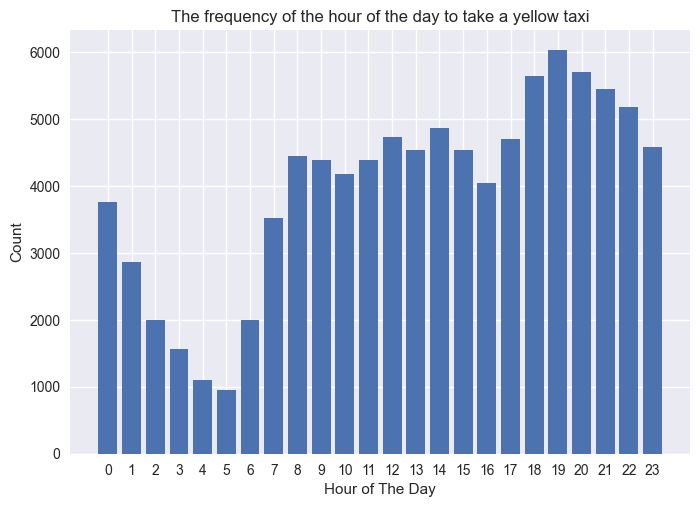

In [150]:
plot_visual_popular_hour_of_day()

### Visualization 2
$Question \ 2$：
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization


Use of the `matplotlib` to visualize and `norm` library to calculate the confidence level. 

Confidence level:

Since this data set is very big, so according to the law of large numbers, it approximately follows the normal distribution.

$\big[\bar Y - z\times \frac{s}{\sqrt{n}}, \bar Y + z\times \frac{s}{\sqrt{n}}\big]$

In [151]:
def get_data_for_visual_n(stmt):
    df=pd.read_sql(stmt,engine.connect())
    return df

In [152]:
def plot_visual_confidence(dataframe):
    fig, ax = plt.subplots(figsize=(6,3))
    from scipy.stats import norm
    z=norm.ppf(0.9)
    x=pd.Series(dataframe.index)
    y=dataframe['distance']
    s=y.std()
    n=dataframe.count()[0]
    y_err=z*s/np.sqrt(n)
    x_ticks = np.linspace(1, 12, 12)
    plt.xticks(x_ticks)
    plt.xlabel('Month')
    plt.ylabel('Distance')
    ax.plot(x,y)
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
    ax.set_title("Confidence level of distanace")
    plt.show()

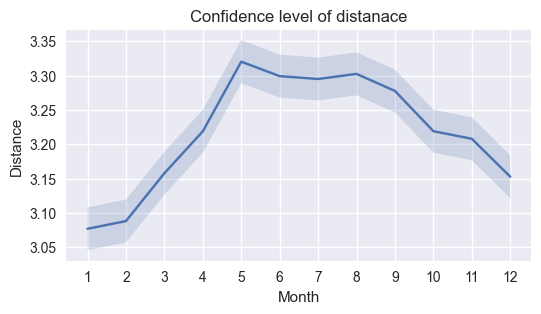

In [153]:
stmt="""
        SELECT Date(pickup_datetime) AS date,distance FROM uber
        UNION 
        SELECT Date(pickup_datetime) AS date,distance FROM taxi
        """
df2 = get_data_for_visual_n(stmt)
df2['date']=pd.to_datetime(df2['date'])
df2['month']=pd.DatetimeIndex(df2['date']).month
distance_mean=pd.DataFrame(df2.groupby(['month'])['distance'].mean())
plot_visual_confidence(distance_mean)

### Visualization 3
$Question \ 3$：Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [154]:
def get_data_for_airports():
    LGA_BOX_COORDS=((40.765,-73.8893),(40.7864,-73.8512))
    JFK_BOX_COORDS=((40.6211,-73.8232),(40.6648,-73.7484))
    EWR_BOX_COORDS=((40.6704,-74.2151),(40.7114,-74.1132))
    
    QUERY_LGA="""
    WITH RECURSIVE ride AS ( 
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude FROM taxi
        WHERE  40.765<dropoff_latitude AND dropoff_latitude< 40.7864 AND -73.8893 <dropoff_longitude AND dropoff_longitude<-73.8512
        UNION ALL
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude FROM uber
        WHERE  40.765<dropoff_latitude AND dropoff_latitude< 40.7864 AND -73.8893 <dropoff_longitude AND dropoff_longitude<-73.8512
        )
    SELECT Day,COUNT(id) FROM ride    
    GROUP BY Day
    ORDER BY COUNT(id) DESC
    """ 
    QUERY_JFK="""
    WITH RECURSIVE ride AS ( 
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude FROM taxi
        WHERE  40.6211 <dropoff_latitude AND dropoff_latitude< 40.6648 AND  -73.8232 <dropoff_longitude AND dropoff_longitude< -73.7484
        UNION ALL
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude FROM uber
        WHERE  40.6211 <dropoff_latitude AND dropoff_latitude< 40.6648  AND  -73.8232 <dropoff_longitude AND dropoff_longitude< -73.7484
        )
    SELECT Day,COUNT(id) FROM ride    
    GROUP BY Day
    ORDER BY COUNT(id) DESC
    """ 
    QUERY_EWR="""
    WITH RECURSIVE ride AS ( 
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id, dropoff_longitude, dropoff_latitude FROM taxi
        WHERE 40.6704<dropoff_latitude AND dropoff_latitude< 40.7214 AND -74.2151 <dropoff_longitude AND dropoff_longitude<-74.1132
        UNION ALL
        SELECT (strftime ("%w",pickup_datetime)+1) AS Day,id,dropoff_longitude, dropoff_latitude FROM uber
        WHERE 40.6704<dropoff_latitude AND dropoff_latitude< 40.7214 AND -74.2151 <dropoff_longitude AND dropoff_longitude<-74.1132
        )
    SELECT Day,COUNT(id) FROM ride    
    GROUP BY Day
    ORDER BY COUNT(id) DESC
     """ 
    LGA=pd.read_sql(QUERY_LGA,engine.connect())
    LGA.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
    LGA_1=LGA[["Day","COUNT(id)"]].set_index("Day")
    
    JFK=pd.read_sql(QUERY_JFK,engine.connect())
    JFK.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
    JFK_1=JFK[["Day","COUNT(id)"]].set_index("Day")
    
    EWR=pd.read_sql(QUERY_EWR,engine.connect())
    EWR.replace([1,2,3,4,5,6,7],["Mon","Tue","Wed","Thur","Fri","Sat","Sun"],inplace=True)
    EWR_1=EWR[["Day","COUNT(id)"]].set_index("Day")
    
    ALL=pd.concat([LGA_1,JFK_1,EWR_1],axis=1)
    ALL.columns=["LGA","JFK","EWR"]
    return ALL,LGA_1,JFK_1,EWR_1

In [155]:
def plot_visual_popular_day_dropoffs(Location):
    ALL,LGA_1,JFK_1,EWR_1 = get_data_for_airports()
    if Location == 'LGA':
        LGA_1.plot(kind='barh',title="LGA",figsize=(7,5))
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'JFK':
        JFK_1.plot(kind='barh',title="JFK",figsize=(7,5))
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'EWR':
        EWR_1.plot(kind='barh',title="EWR",figsize=(7,5))
        plt.xlabel('Numbers of dropoffs')
    elif Location == 'ALL':
        ALL.plot(kind='bar',figsize=(10,5))
        plt.ylabel('Numbers of dropoffs')
    else:
        Print("---Wrong Airport Location---")

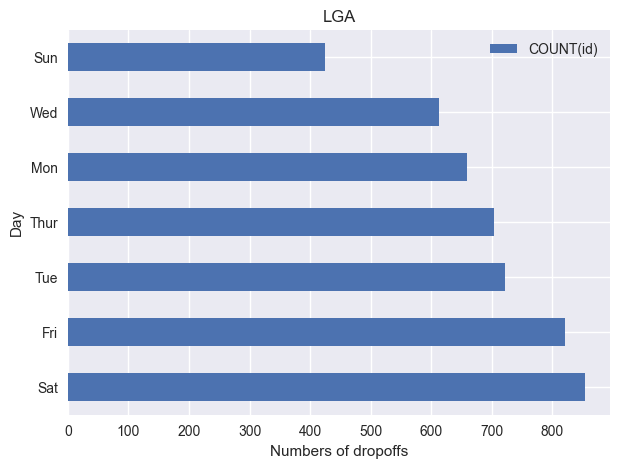

In [156]:
plot_visual_popular_day_dropoffs("LGA")

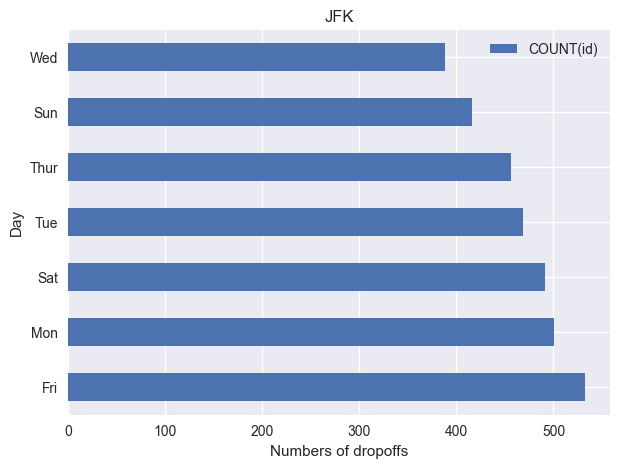

In [157]:
plot_visual_popular_day_dropoffs("JFK")

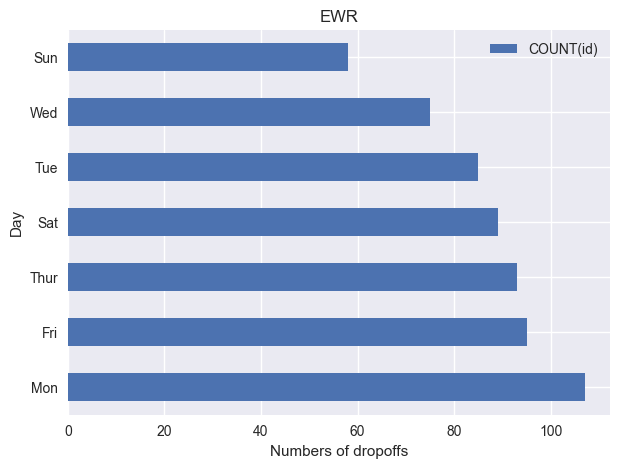

In [158]:
plot_visual_popular_day_dropoffs("EWR")

### Extra Visualization(1)
$For\ Question \ 3$：

_Comparison of The Three Airports of Each Day_

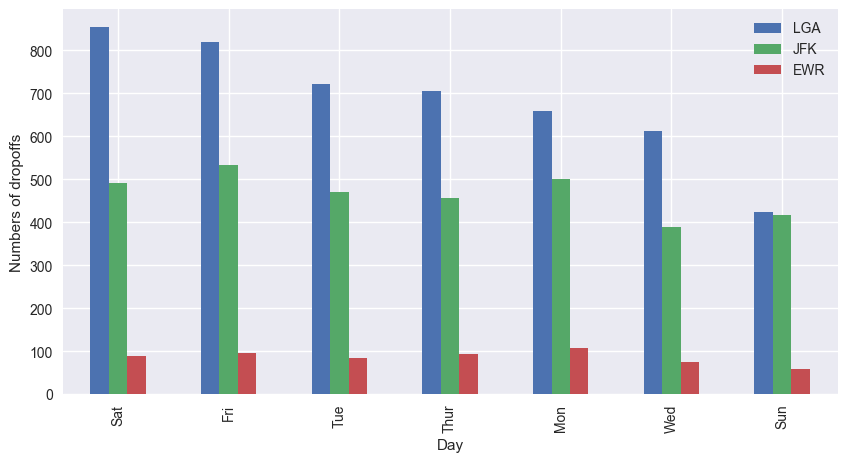

In [159]:
plot_visual_popular_day_dropoffs("ALL")

### Visualization 4
$Question \ 4$：Create a heatmap of all hired trips over a map of the area

Use keplergl library to get the heatmap of the location

In [163]:
stmt="""
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM uber
        UNION
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM taxi
        """
df4 = get_data_for_visual_n(stmt)

In [167]:
def plot_visual_heatmap(dataframe):
    from keplergl import KeplerGl
    map1=KeplerGl(height=500)
    map1.add_data(data=dataframe,name='New York City Taxi and Uber Trips')
    return map1
plot_visual_heatmap(df4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York City Taxi and Uber Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

### Visualization 5
$Question \ 5$：Create a scatter plot that compares tip amount versus distance.

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [66]:
def get_data_for_tip_vs_distance():
    QUERY="""
    SELECT tip, distance FROM taxi
    WHERE tip>=0 AND distance >0
    """
    dataframe =pd.read_sql(QUERY,engine.connect())
    return dataframe

In [67]:
def plot_visual_tip_vs_distance():
    x= get_data_for_tip_vs_distance()
    plt.scatter(x['distance'],x['tip'])
    plt.xlabel("Distance")
    plt.xlim(0,60)
    plt.ylabel("Tip Amount")
    plt.title('Scatter plot of tip and distance')
    plt.show()

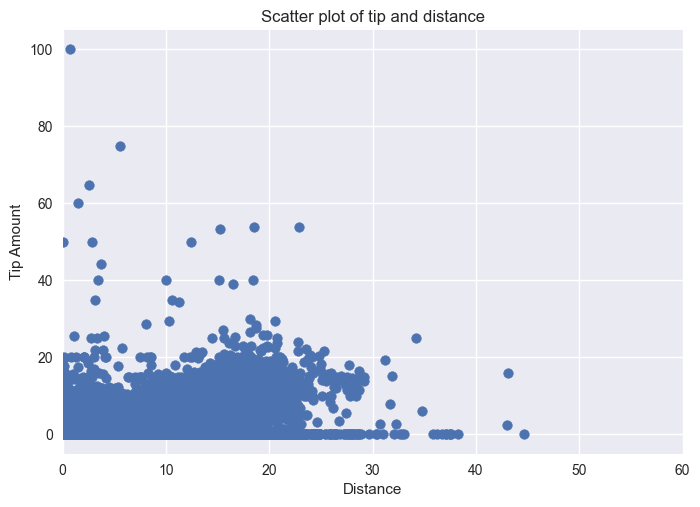

In [68]:
plot_visual_tip_vs_distance()

### Extra Visualization(2)
$For\ Question \ 5$：

Scatter plot with points of different colors and sizes of tip amount versus distance.

The size of the point represents The number of people in a particular tip group

In [69]:
def get_data_for_tip_vs_distance_Extra():
    QUERY="""
    SELECT COUNT(id),tip, distance FROM taxi
    WHERE tip>=0 AND distance >0
    GROUP BY tip
    """
    dataframe = pd.read_sql(QUERY,engine.connect())
    return dataframe

In [70]:
def plot_visual_tip_vs_distance_Extra():
    c = get_data_for_tip_vs_distance_Extra()
    c.columns=['COUNT(id)','tip','distance']
    x = c["tip"]
    y = c["distance"]
    
    colors = 0.01*c["COUNT(id)"]# values for colors
    sizes =  2* c["COUNT(id)"] # Number count for sizes of the points being plotted
    
    plt.xlabel("Distance")
    plt.ylabel("Tip Amount")
    plt.scatter(x, y, c=colors, s=sizes, alpha=0.5, cmap='viridis')
    plt.colorbar()

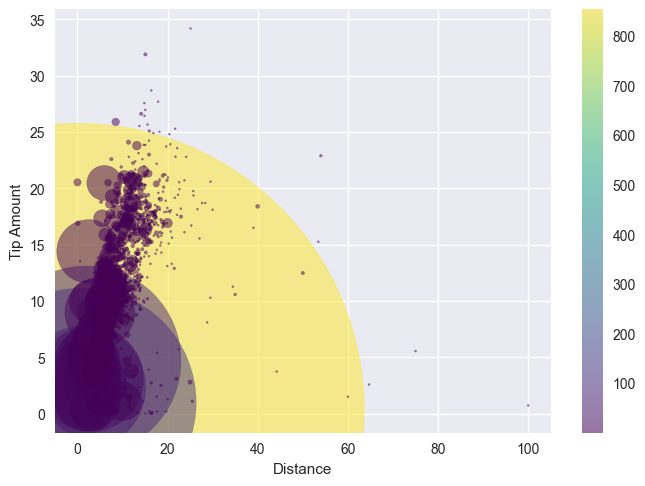

In [71]:
plot_visual_tip_vs_distance_Extra()

### Visualization 6
$Question \ 6$：Create another scatter plot that compares tip amount versus precipitation amount.

Use the pandas to merge the tip amount and precipitation data and then use the matplot library to get the scatter plot.

In [72]:
stmt="""
SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS dateh, pickup_datetime,tip
FROM taxi
"""
stmt1="""
SELECT strftime('%Y-%m-%d %H',date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather
"""
taxidf=get_data_for_visual_n(stmt)
hourdf=get_data_for_visual_n(stmt1)
df7=pd.merge(taxidf,hourdf,how='left')

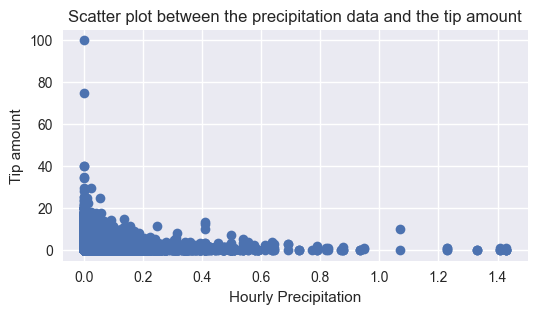

In [73]:
def plot_visual_6(dataframe):
    plt.figure(figsize=(6,3))
    plt.plot(dataframe['hourlyprecipitation'],dataframe['tip'],'o')
    plt.xlabel('Hourly Precipitation')
    plt.ylabel('Tip amount')
    plt.title('Scatter plot between the precipitation data and the tip amount')
    plt.show()
plot_visual_6(df7)